## Data Collection

In [ ]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808329 sha256=c0433e43610b72af708270858fc10d04ab3e0e69c3e7ad0e9fef746c7a2ed22e
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from lightfm import LightFM
from lightfm.evaluation import recall_at_k, precision_at_k, auc_score, reciprocal_rank
import timeit
from lightfm.data import Dataset
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from numpy.linalg import norm
import random

In [ ]:
# Load data
movies = pd.read_csv('https://gitlab.com/start-ide/Ares/-/raw/main/datasets/movies.dat', sep='::', header=None, names=['movie_id', 'title', 'genre'], engine='python', encoding='ISO-8859-1')
ratings = pd.read_csv('https://gitlab.com/start-ide/Ares/-/raw/main/datasets/ratings.dat', sep='::', engine='python', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])
users = pd.read_csv('https://gitlab.com/start-ide/Ares/-/raw/main/datasets/users.dat', sep='::', engine='python', header=None, names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])

# Preprocess data
movies['genre'] = movies['genre'].apply(lambda x: x.split('|')[0])
movies['movie_id'] = movies['movie_id'].apply(lambda x: int(x))
ratings['user_id'] = ratings['user_id'].apply(lambda x: int(x))
ratings['movie_id'] = ratings['movie_id'].apply(lambda x: int(x))
ratings['rating'] = ratings['rating'].apply(lambda x: float(x))
ratings = ratings[ratings['rating'] >= 1.0]
ratings['timestamp'] = ratings['timestamp'].apply(lambda x: int(x))

In [ ]:
movies.head(5)

movie_id                               title      genre
0         1                    Toy Story (1995)  Animation
1         2                      Jumanji (1995)  Adventure
2         3             Grumpier Old Men (1995)     Comedy
3         4            Waiting to Exhale (1995)     Comedy
4         5  Father of the Bride Part II (1995)     Comedy

In [ ]:
len(movies["movie_id"])

3883

In [ ]:
users.head(5)

user_id gender  age  occupation zip_code
0        1      F    1          10    48067
1        2      M   56          16    70072
2        3      M   25          15    55117
3        4      M   45           7    02460
4        5      M   25          20    55455

In [ ]:
ratings.head(5)

user_id  movie_id  rating  timestamp
0        1      1193     5.0  978300760
1        1       661     3.0  978302109
2        1       914     3.0  978301968
3        1      3408     4.0  978300275
4        1      2355     5.0  978824291

In [ ]:
num_users = ratings['user_id'].nunique()
num_items = ratings['movie_id'].nunique()

user_ids = ratings['user_id'].unique().tolist()
user_map = {id:i for i,id in enumerate(user_ids)}

item_ids = ratings['movie_id'].unique().tolist()
item_map = {id:i for i,id in enumerate(item_ids)}

interactions = {}
user_next_click_map = {}
for _, row in ratings.iterrows():
    user_idx = user_map[row['user_id']]
    item_idx = item_map[row['movie_id']]
    user_next_click_map[row['user_id']] = (row.user_id,row.movie_id)
    if row.user_id in interactions:
      interactions[row.user_id].append(row.movie_id)
    else:
      interactions[row.user_id] = []
      interactions[row.user_id].append(row.movie_id)

In [ ]:
interactions[1]

[1193.0,
 661.0,
 914.0,
 3408.0,
 2355.0,
 1197.0,
 1287.0,
 2804.0,
 594.0,
 919.0,
 595.0,
 938.0,
 2398.0,
 2918.0,
 1035.0,
 2791.0,
 2687.0,
 2018.0,
 3105.0,
 2797.0,
 2321.0,
 720.0,
 1270.0,
 527.0,
 2340.0,
 48.0,
 1097.0,
 1721.0,
 1545.0,
 745.0,
 2294.0,
 3186.0,
 1566.0,
 588.0,
 1907.0,
 783.0,
 1836.0,
 1022.0,
 2762.0,
 150.0,
 1.0,
 1961.0,
 1962.0,
 2692.0,
 260.0,
 1028.0,
 1029.0,
 1207.0,
 2028.0,
 531.0,
 3114.0,
 608.0,
 1246.0]

## Tuning Model

In [ ]:
dataset = Dataset()
dataset.fit(users=ratings['user_id'], items=ratings['movie_id'])
interactions_sparse, _ = dataset.build_interactions((row.user_id,row.movie_id) for row in ratings[['user_id', 'movie_id']].itertuples(index=False))

In [ ]:
def algorithmTuningTrainning(interactions_sparse):
  loss = 'warp'
  learning_rate_tuning = [0.01, 0.05, 0.1, 0.5]
  k_tuning = [4]
  # k_tuning = [4, 8, 16, 32, 64, 128, 256, 512]
  random_state_tuning = [100]
  # random_state_tuning = [None, 5, 10, 20, 50, 100]

  precision_bucket = []

  for k in k_tuning:
    for learning_rate in learning_rate_tuning:
      for random_state in random_state_tuning:
        model = LightFM(loss=loss, k=k, learning_rate=learning_rate, random_state=random_state)
        model.fit(interactions_sparse, num_threads=4)
        precision_score = precision_at_k(model, interactions_sparse, k=20).mean()

        precision_bucket.append({
            "model": model,
            "k": k,
            "learning_rate": learning_rate,
            "random_state": random_state,
            "precision": precision_score
        })

  return precision_bucket

In [ ]:
precision_bucket = algorithmTuningTrainning(interactions_sparse)

In [ ]:
precision_bucket

[{'model': <lightfm.lightfm.LightFM at 0x7adbece8fa30>,
  'k': 4,
  'learning_rate': 0.01,
  'random_state': 100,
  'precision': 0.43167216},
 {'model': <lightfm.lightfm.LightFM at 0x7adbece8efb0>,
  'k': 4,
  'learning_rate': 0.05,
  'random_state': 100,
  'precision': 0.5030712},
 {'model': <lightfm.lightfm.LightFM at 0x7adc238cb220>,
  'k': 4,
  'learning_rate': 0.1,
  'random_state': 100,
  'precision': 0.5286838},
 {'model': <lightfm.lightfm.LightFM at 0x7adbece8fdc0>,
  'k': 4,
  'learning_rate': 0.5,
  'random_state': 100,
  'precision': 0.017028145}]

In [ ]:
res = {}
for dic in precision_bucket:
    # checking for key presence and updating max
    if "precision" in res:
      if res["precision"] < dic["precision"]:
        res = dic
    else:
      res = dic
res

{'model': <lightfm.lightfm.LightFM at 0x7adc238cb220>,
 'k': 4,
 'learning_rate': 0.1,
 'random_state': 100,
 'precision': 0.5286838}

In [ ]:
len(user_next_click_map)

6040

In [ ]:
example_user_id = user_ids[0]
predict_example_user_id = []
for i in item_ids:
  predict_example_user_id.append((example_user_id, i))
  if len(predict_example_user_id) > 10:
    break

interactions_sparse_test, _ = dataset.build_interactions(predict_example_user_id)
scores = res["model"].predict(user_ids=interactions_sparse_test.row, item_ids=interactions_sparse_test.col)

In [ ]:
scores

array([ 0.9707136 , -0.61281943,  0.58117634, -0.0716588 ,  0.8576294 ,
        1.1201783 , -0.15975554,  0.66856134,  0.549242  ,  1.9232615 ,
        0.82219094], dtype=float32)

In [ ]:
predict_example_user_id

[(1, 1193),
 (1, 661),
 (1, 914),
 (1, 3408),
 (1, 2355),
 (1, 1197),
 (1, 1287),
 (1, 2804),
 (1, 594),
 (1, 919),
 (1, 595)]

In [ ]:
ex_pred_top_n_user_id = np.array(item_ids)
temp = scores

sr_temp = temp.argsort()
sorted_ex_pred_top_n_user_id = ex_pred_top_n_user_id[sr_temp[::-1]]
sorted_ex_pred_top_n_user_id

array([ 919, 1197, 1193, 2355,  595, 2804,  914,  594, 3408, 1287,  661])

In [ ]:
ex_pred_top_n_user_id

array([1193,  661,  914, ..., 2845, 3607, 2909])

In [ ]:
user_next_click_map[example_user_id][1]

1246.0

In [ ]:
for i in range(len(sorted_ex_pred_top_n_user_id)):
  if user_next_click_map[example_user_id][1] == sorted_ex_pred_top_n_user_id[i]:
    print(i)
    break

In [ ]:
moviesDict = {}
for _, row in movies.iterrows():
  moviesDict[row.movie_id] = {
      "title": row.title,
      "genre": row.genre
  }

temp = {}
for item_id in item_ids:
  temp[item_id] = moviesDict[item_id]
moviesDict = temp

In [ ]:
moviesDict[1]

{'title': 'Toy Story (1995)', 'genre': 'Animation'}

## Reposition and Evaluation

In [ ]:
def getEvaluationValue(user_next_interaction_id, sorted_ex_pred_top_n_user_id):
  sentences = []
  target = ""
  for i in range(len(sorted_ex_pred_top_n_user_id)):
    if i <= 20:
      sen_temp = moviesDict[sorted_ex_pred_top_n_user_id[i]]
      sentences.append(sen_temp["title"] + " " + sen_temp["genre"])

    if user_next_interaction_id == sorted_ex_pred_top_n_user_id[i]:
      target = sen_temp["title"] + " " + sen_temp["genre"]

  bow = []
  for i in sentences:
    for j in i.split(" "):
      if j not in bow:
        bow.append(j)

  sen_vec = []
  target_vec = []
  for i in sentences:
    temp_sen_vec = []
    for j in bow:
      if j in i:
        temp_sen_vec.append(1)
      else:
        temp_sen_vec.append(0)
    sen_vec.append(temp_sen_vec)

  for j in bow:
    if j in target:
      target_vec.append(1)
    else:
      target_vec.append(0)

  similarityVec = []
  variationVec = []
  for i in sen_vec:
    cosine = np.dot(target_vec,i)/(norm(target_vec)*norm(i))
    similarityVec.append(cosine)
    variationVec.append(1-cosine)

  novelty = 1 / (sum(similarityVec) / len(similarityVec))
  variation = 1 / (sum(variationVec) / len(variationVec))
  serendipity = novelty * variation

  return novelty, variation, serendipity

In [ ]:
def utilizeData(items):
  bows = []
  word_count = {}
  tf = {}
  idf = {}
  tf_idf = {}
  for item in items:
    sen = (moviesDict[item]["title"] + " " + moviesDict[item]["genre"]).split(" ")
    sen_f = {}
    for j in sen:
      if j in sen_f:
        sen_f[j] += 1
      else:
        sen_f[j] = 1

      if j in word_count:
        word_count[j] += 1
      else:
        word_count[j] = 1

      if j not in bows:
        bows.append(j)

    sen_tf = {}
    for i in sen_f:
      sen_tf[i] = sen_f[i] / len(sen)
    tf[item] = sen_tf

  for item in items:
    sen = (moviesDict[item]["title"] + " " + moviesDict[item]["genre"]).split(" ")
    for j in sen:
      if j not in idf:
        idf[j] = np.log10(len(moviesDict) / (word_count[j] + 1))

  for i in tf:
    tf_i = tf[i]
    tf_idf_i = {}
    for j in tf_i:
      tf_idf_i[j] = tf_i[j] * idf[j]

    tf_idf[i] = tf_idf_i
  # print(tf_idf)

  sen_vec = {}
  for item in items:
    sen = (moviesDict[item]["title"] + " " + moviesDict[item]["genre"]).split(" ")
    temp_sen_vec = {}
    for j in bows:
      if j in sen:
        if j in temp_sen_vec:
          temp_sen_vec[j] += 1
        else:
          temp_sen_vec[j] = 1
      else:
        temp_sen_vec[j] = 0
    temp_sen_vec = list(temp_sen_vec.values())
    sen_vec[item] = {
        "list": temp_sen_vec,
        "norm": norm(temp_sen_vec)
    }

  return bows, word_count, tf_idf, sen_vec

In [ ]:
def roulletPositionClick():
  # Probabilities for positions 1 to 10
  probabilities = [0.45, 0.15, 0.12, 0.07, 0.05, 0.07, 0.02, 0.03, 0.01, 0.03]

  # Generate a random number between 0 and 1
  random_number = random.random()

  # Initialize cumulative probability
  cumulative_probability = 0

  # Iterate through positions and select one
  selected_position = None
  for i, probability in enumerate(probabilities):
      cumulative_probability += probability
      if random_number <= cumulative_probability:
          selected_position = i + 1  # Add 1 to convert to position number (1-10)
          break

  # print(f"Selected Position: {selected_position}")
  return selected_position

In [ ]:
coverage_n = {
    "rand-top-n": {},
    "fair-pairs": [],
    "random-pairs": [],
    "ares": [],
}
novelty_n = {
    "rand-top-n": [],
    "fair-pairs": [],
    "random-pairs": [],
    "ares": [],
}
variation_n = {
    "rand-top-n": [],
    "fair-pairs": [],
    "random-pairs": [],
    "ares": [],
}
serendipity_n = {
    "rand-top-n": [],
    "fair-pairs": [],
    "random-pairs": [],
    "ares": [],
}
top_20_prediction_score = []

for user_id in user_ids:
  predict_example_user_id = []
  for i in item_ids:
    predict_example_user_id.append((user_id, i))

  interactions_sparse_test, _ = dataset.build_interactions(predict_example_user_id)
  scores = res["model"].predict(user_ids=interactions_sparse_test.row, item_ids=interactions_sparse_test.col)

  ex_pred_top_n_user_id = np.array(item_ids)
  temp = scores

  top_20 = np.array(scores)
  top_20[::-1].sort()
  top_20_prediction_score.append(top_20)

  sr_temp = temp.argsort()
  sorted_ex_pred_top_n_user_id = ex_pred_top_n_user_id[sr_temp[::-1]]

  sorted_ex_pred_top_n_user_id = sorted_ex_pred_top_n_user_id[:100]
  bows, word_count, tf_idf, sen_vec = utilizeData(sorted_ex_pred_top_n_user_id)
  next_item_interaction = sorted_ex_pred_top_n_user_id[roulletPositionClick()]
  # print("sorted_ex_pred_top_n_user_id", len(sorted_ex_pred_top_n_user_id))
  # print("ex_pred_top_n_user_id", ex_pred_top_n_user_id)
  # print("len", len(ex_pred_top_n_user_id), len(sorted_ex_pred_top_n_user_id))
  # print("next_item_interaction", next_item_interaction)

  # RandTopN
  randTopN = []
  for i in range(20):
    tempRandTopN = np.array(sorted_ex_pred_top_n_user_id)
    np.random.shuffle(tempRandTopN)
    randTopN.append(tempRandTopN)

  # FairPairs
  fairPairs = np.array(sorted_ex_pred_top_n_user_id)
  for i in range(int(len(sorted_ex_pred_top_n_user_id))):
    k = np.random.randint(0,1)
    if k == 0:
      selected_swap_position = random.randrange(1, (20)-2, 2)
      selected_swap_position_1 = random.randrange(1, (len(sorted_ex_pred_top_n_user_id))-2, 2)
      tempFairPairs = fairPairs[selected_swap_position]
      fairPairs[selected_swap_position] = fairPairs[selected_swap_position_1]
      fairPairs[selected_swap_position_1] = tempFairPairs
    else:
      selected_swap_position = random.randrange(0, (20)-2, 2)
      selected_swap_position_1 = random.randrange(0, (len(sorted_ex_pred_top_n_user_id))-2, 2)
      tempFairPairs = fairPairs[selected_swap_position]
      fairPairs[selected_swap_position] = fairPairs[selected_swap_position_1]
      fairPairs[selected_swap_position_1] = tempFairPairs

  # RandomPairs
  randomPairs = np.array(sorted_ex_pred_top_n_user_id)
  for i in range(int(len(sorted_ex_pred_top_n_user_id))):
    k = random.randrange(1, len(sorted_ex_pred_top_n_user_id)-2, 1)
    tempRandomPairs = randomPairs[k]
    randomPairs[k] = randomPairs[1]
    randomPairs[1] = tempRandomPairs

  # ARES
  history_items = interactions[user_id][-20:]
  # print(history_items)
  targets = {}
  for i in history_items:
    sen = (moviesDict[i]["title"] + " " + moviesDict[i]["genre"]).split(" ")
    target_vec = []
    for j in bows:
      if j in sen:
        target_vec.append(1)
      else:
        target_vec.append(0)
    targets[i] = target_vec

  similarityTarget = {}
  for i in targets:
    similarityVec = {}
    target_vec = targets[i]
    norm_target_vec = norm(target_vec)
    for j in sen_vec:
      sen_vec_j = sen_vec[j]
      cosine = np.dot(target_vec,sen_vec_j["list"])/(norm_target_vec*sen_vec_j["norm"])
      similarityVec[j] = cosine
    similarityTarget[i] = similarityVec

  context_fitnes = {}
  for simTarget in similarityTarget:
    for i in tf_idf:
      tf_idf_i = 0
      for j in tf_idf[i]:
        tf_idf_i += tf_idf[i][j]
      cntx = tf_idf_i + similarityTarget[simTarget][i]
      if i in context_fitnes:
        context_fitnes[i] += cntx
      else:
        context_fitnes[i] = cntx

  context_fitnes = np.array(list(context_fitnes.values()))
  context_fitnes[::-1].sort()
  ares_temp = context_fitnes.argsort()
  ares_temp2 = np.array(sorted_ex_pred_top_n_user_id)
  ares = ares_temp2[ares_temp[::-1]]

  for randTopNI in range(len(randTopN)):
    if randTopNI not in coverage_n["rand-top-n"]:
      coverage_n["rand-top-n"][randTopNI] = []
    for i in range(len(randTopN[randTopNI])):
      if next_item_interaction == randTopN[randTopNI][i]:
        # print("Ares", i)
        coverage_n["rand-top-n"][randTopNI].append(i)
        break

  # for i in range(len(sorted_ex_pred_top_n_user_id)):
  #   if next_item_interaction == sorted_ex_pred_top_n_user_id[i]:
  #     # print("Normal", i)
  #     coverage_n["normal"].append(i)
  #     break

  for i in range(len(fairPairs)):
    if next_item_interaction == fairPairs[i]:
      # print("Normal", i)
      coverage_n["fair-pairs"].append(i)
      break

  for i in range(len(randomPairs)):
    if next_item_interaction == randomPairs[i]:
      # print("Normal", i)
      coverage_n["random-pairs"].append(i)
      break

  for i in range(len(ares)):
    if next_item_interaction == ares[i]:
      # print("Ares", i)
      coverage_n["ares"].append(i)
      break

  # novelty, variation, serendipity = getEvaluationValue(next_item_interaction, sorted_ex_pred_top_n_user_id)
  # novelty_n["normal"].append(novelty)
  # variation_n["normal"].append(variation)
  # serendipity_n["normal"].append(serendipity)

  maxNovelty = 0
  maxVariation = 0
  maxSerendipity = 0
  for randTopNI in range(len(randTopN)):
    novelty, variation, serendipity = getEvaluationValue(next_item_interaction, randTopN[randTopNI])
    if maxNovelty < novelty:
      maxNovelty = novelty
    if maxVariation < variation:
      maxVariation = variation
    if maxSerendipity < serendipity:
      maxSerendipity = serendipity

  novelty_n["rand-top-n"].append(maxNovelty)
  variation_n["rand-top-n"].append(maxVariation)
  serendipity_n["rand-top-n"].append(maxSerendipity)

  novelty, variation, serendipity = getEvaluationValue(next_item_interaction, fairPairs)
  novelty_n["fair-pairs"].append(novelty)
  variation_n["fair-pairs"].append(variation)
  serendipity_n["fair-pairs"].append(serendipity)

  novelty, variation, serendipity = getEvaluationValue(next_item_interaction, randomPairs)
  novelty_n["random-pairs"].append(novelty)
  variation_n["random-pairs"].append(variation)
  serendipity_n["random-pairs"].append(serendipity)

  novelty, variation, serendipity = getEvaluationValue(next_item_interaction, ares)
  novelty_n["ares"].append(novelty)
  variation_n["ares"].append(variation)
  serendipity_n["ares"].append(serendipity)

  # print(user_id)
  # print(randTopN[0])
  # print(fairPairs)
  # print(randomPairs)
  if len(novelty_n["ares"]) >= 100:
    break

<ipython-input-30-aafe7bbbb366>:106: RuntimeWarning: invalid value encountered in double_scalars
  cosine = np.dot(target_vec,sen_vec_j["list"])/(norm_target_vec*sen_vec_j["norm"])


Y Positive [91, 91, 90, 89, 89, 89, 89, 89, 86, 85, 84, 83, 82, 82, 82, 81, 80, 80, 80, 80]
Y Negative [9, 9, 10, 11, 11, 11, 11, 11, 14, 15, 16, 17, 18, 18, 18, 19, 20, 20, 20, 20]


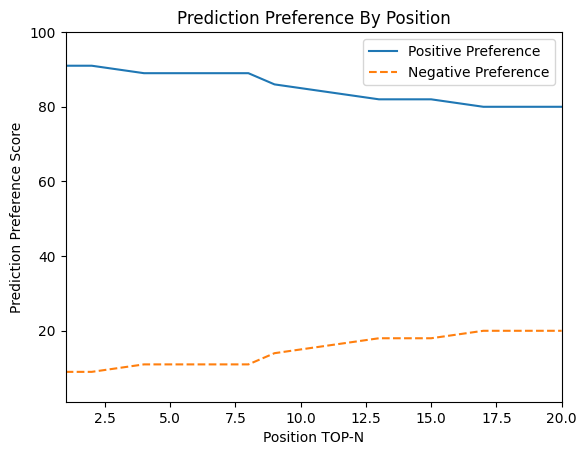

In [ ]:
import matplotlib.pyplot as plt

x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
y_positive = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
y_negative = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

for i in top_20_prediction_score:
  temp = i[:20]
  for j in range(len(temp)):
    if temp[j] > 0.0:
      y_positive[j] += 1
    else:
      y_negative[j] += 1

print("Y Positive", y_positive)
print("Y Negative", y_negative)

plt.xlabel('Position TOP-N')
plt.ylabel('Prediction Preference Score')
plt.xlim(1, 20)
plt.ylim(1, 100)
plt.title('Prediction Preference By Position')
plt.plot(x, y_positive, label = "Positive Preference", linestyle="-")
plt.plot(x, y_negative, label = "Negative Preference", linestyle="--")
plt.legend()
plt.show()

In [ ]:
for i in coverage_n:
  print(i)
  if i == "rand-top-n":
    maxCoverage = 0
    for j in coverage_n[i]:
      coverage = 0
      for k in coverage_n[i][j]:
        if k <= 10:
          coverage += 1
      if maxCoverage < coverage:
        maxCoverage = coverage
    print ("Coverage :", (maxCoverage / len(user_ids)) * 100)
  else:
    coverage = 0
    for j in coverage_n[i]:
      if j <= 10:
        coverage += 1
    print ("Coverage :", (coverage / len(user_ids)) * 100)
  novelty = sum(novelty_n[i]) / len(novelty_n[i])
  variation = sum(variation_n[i]) / len(variation_n[i])
  serendipity = sum(serendipity_n[i]) / len(serendipity_n[i])
  print ("Novelty :", novelty)
  print ("Variation :", variation)
  print ("Serendipity :", serendipity)
  print("============================")

rand-top-n
Coverage : 11.556291390728477
Novelty : 15.739543798594763
Variation : 1.444028246905286
Serendipity : 16.8130985426509
fair-pairs
Coverage : 41.67218543046358
Novelty : 6.475425156812392
Variation : 1.2546854523641358
Serendipity : 7.7301106091765055
random-pairs
Coverage : 28.013245033112582
Novelty : 6.600127062134089
Variation : 1.2439819628067974
Serendipity : 7.844109024940881
ares
Coverage : 94.68543046357615
Novelty : 5.728569551444308
Variation : 1.2891023982954823
Serendipity : 7.017671949739807
